In [1]:
import sys
sys.path.append('../phantoms')

from utils import LearnedSO2Calculator
import patato as pat

import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops
from skimage.transform import rotate, SimilarityTransform, warp, AffineTransform
from palettable.cartocolors.qualitative import Pastel_3

import numpy as np

from patato.useful_utilities import (
    add_axis_label,
    add_subfigure_label,
    linear_regression,
)

import scienceplots  # noqa
import matplotlib

plt.style.use(["science", "nature", "no-latex"])

matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["figure.constrained_layout.use"] = True

%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [2]:
def rotate_image(im, theta, ax=None, scale=1, lines=None):
    x = im.get_array().copy()
    rows, cols = x.shape  # width, height
    # assert rows == cols

    theta = theta * np.pi / 180

    # Translate the image
    props = regionprops((~np.isnan(x)).astype(np.uint8))
    prop = max(props, key=lambda x: x.area)
    rowc, colc = prop.centroid

    # rotation around center
    blob_center = np.array((colc, rowc))
    center = np.array((cols, rows)) / 2 - 0.5

    tform1 = SimilarityTransform(translation=blob_center)
    tform2 = SimilarityTransform(rotation=theta)
    tform3 = SimilarityTransform(translation=-center)
    tform = tform3 + tform2 + tform1

    d = warp(x, tform, cval=np.nan)
    im.set_data(d)

    x0, x1, y0, y1 = im.get_extent()
    upper = False
    linetform = (
        AffineTransform(translation=(0.5, 0.5))
        + AffineTransform(
            scale=((x1 - x0) / (cols), (y1 - y0) / (rows) * (-1 if upper else 1))
        )
        + AffineTransform(translation=(x0, y0 * (-1 if upper else 1)))
    )

    if lines is not None:
        for y in lines:
            v = np.array(y.get_data())
            test = linetform(tform.inverse(linetform.inverse(v.T))).T
            y.set_data(test)

    # for scale, we'll just adjust the axis limits.
    if scale != 1:
        if ax is None:
            raise ValueError(
                "For rescaling, axes must be passed as a keyword argument."
            )
        else:
            a, b = ax.get_xlim()
            ax.set_xlim(a / scale, b / scale)
            a, b = ax.get_ylim()
            ax.set_ylim(a / scale, b / scale)
    return im

In [3]:
# Heavily pigmented image:

pa_pig = pat.PAData.from_hdf5("../data/mice/b6/Scan_40.hdf5")
roi_pig = pa_pig.get_rois()["body_", "0"]
pa_pig.set_default_recon()

# B6 non pigmented
pa_b6n = pat.PAData.from_hdf5("../data/mice/b6/Scan_2.hdf5")
roi_b6n = pa_b6n.get_rois()["body_", "0"]
pa_b6n.set_default_recon()

# Albino
pa_alb = pat.PAData.from_hdf5("../data/mice/albino/Scan_5.hdf5")
roi_alb = pa_alb.get_rois()["body_", "0"]
pa_alb.set_default_recon()

In [4]:
def fix_clims(ims, lower=None, upper=None):
    min_c = np.inf
    max_c = -np.inf
    for i in ims:
        a, b = i.get_clim()
        if min_c > a:
            min_c = a
        if max_c < b:
            max_c = b
    if lower is not None:
        min_c = lower
    if upper is not None:
        max_c = upper
    for i in ims:
        i.set_clim((min_c, max_c))

In [5]:
learned_so2_calc = LearnedSO2Calculator(model="SKIN", model_path="../simulations/learned_decolouring/models_GBR_all")

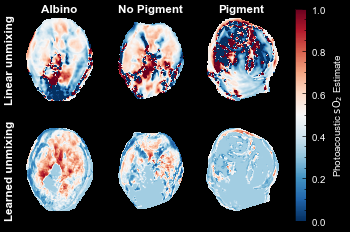

In [44]:
subfigd = plt.figure(figsize=(2*5.25/3, 4*5.25/9))

image_scale = 1.2

labels = ["Albino", "No Pigment", "Pigment"]
image_datasets = [pa_alb, pa_b6n, pa_pig]

rotation = []

# --------------- Image grid ------------------------ #
subfigd.set_facecolor("black")

im_grid = subfigd.subplots(2, 3, sharex=True, sharey=True).flatten()

recs = []
thbs = []
so2s = []

df = pd.read_pickle("intermediate results/lineplots.pd").set_index("Scan name")

# Make the image grid.
for i in range(len(im_grid)):
    dataset = image_datasets[i % 3][0:1]
    wavelength = np.argmin(np.abs(dataset.get_wavelengths() - 800))
    dataset.set_default_recon()
    mask = dataset.get_rois()["body_", "0"]

    # Get the rim/core rois to add outline to figure:
    rois = dataset.get_rois(rim_core_distance=0.001, get_rim_cores=["body_"])
    roi_core = rois["body.core_", "0"]
    roi_rim = rois["body.rim_", "0"]
    mask_2 = dataset.get_rois()["body_", "1"]
    roi_core = roi_core.get_polygon() & mask_2.get_polygon()
    roi_rim = roi_rim.get_polygon() & mask_2.get_polygon()

    if i // 3 == 1:
        so2, _, _ = learned_so2_calc.run(dataset.get_scan_reconstructions(), None)
        im = so2.imshow(ax=im_grid[i], roi_mask=mask, scale_kwargs={
                "fixed_value": 0.005,
                "scale_loc": "none",
                "width_fraction": 0.05,
                "pad": 0,
                "border_pad": 0,
            }
            if i == 0
            else {},
            scalebar=True if i == 0 else False)
        rotate_image(im, rotation[i % 3])
        thbs.append(im)
    elif i // 3 == 0:
        # Add line plot through the mouse.
        xline = [x.item() for x in df.loc[dataset.get_scan_name(), "x line"]]
        yline = [x.item() for x in df.loc[dataset.get_scan_name(), "y line"]]

        # Apply rotation and save for later plots:
        rotation.append(
            180 * np.arctan2(yline[1] - yline[0], xline[1] - xline[0]) / np.pi
        )
        im = dataset.get_scan_so2().imshow(ax=im_grid[i], roi_mask=mask, clim=(0, 1), scalebar=False)
        rotate_image(im, rotation[i % 3])
        so2s.append(im)
        

a, b = im_grid[0].get_xlim()
im_grid[0].set_xlim(a / image_scale, b / image_scale)
a, b = im_grid[0].get_ylim()
im_grid[0].set_ylim(a / image_scale, b / image_scale)

fix_clims(thbs, 0, 1)
fix_clims(so2s, 0, 1)

cbar_so2 = plt.colorbar(so2s[0], ax=im_grid)
cbar_so2.ax.tick_params(color="k", labelcolor="w")
cbar_so2.ax.tick_params(color="k", labelcolor="w", which="minor")

cbar_thb.ax.set_yticks([0, thbs[0].get_clim()[1]], [0, "MAX"])

cbar_pa.set_label("PA (a.u.)", color="w")
cbar_thb.set_label("THb (a.u.)", color="w")
cbar_so2.set_label("Photoacoustic $\mathrm{sO_2}$ Estimate", color="w")

for i, label_ax in enumerate(im_grid[:3]):
    label_ax.annotate(
        labels[i],
        xy=(0.5, 1.05),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize="large",
        color="w",
        fontweight="bold",
    )

im_grid[0].annotate(
        "Linear unmixing",
        xy=(-0.1, 0.5),
        xycoords="axes fraction",
        ha="center",
        va="center",
        fontsize="large",
        color="w",
        fontweight="bold",
        rotation = 90,
    )
im_grid[3].annotate(
        "Learned unmixing",
        xy=(-0.1, 0.5),
        xycoords="axes fraction",
        ha="center",
        va="center",
        fontsize="large",
        color="w",
        fontweight="bold",
        rotation = 90,
    )
    
plt.savefig("../figures/mice_learned_unmixing.png", dpi=300)
plt.savefig("../figures/mice_learned_unmixing.pdf", dpi=300)
plt.show()